In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(19)
from onboard.client import OnboardClient
from onboard.client.dataframes import points_df_from_streaming_timeseries
from onboard.client.models import PointSelector, TimeseriesQuery, PointData
from datetime import datetime, timezone, timedelta
from typing import List
import pytz
from onboard.client import RtemClient
import missingno as msno
import seaborn as sns
from matplotlib.pyplot import figure
from tqdm import tqdm
from matplotlib.ticker import FormatStrFormatter
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from heatmap_fn import heatmap_sensor_and_equipment

In [23]:
building_api_key = 'API_KEY'
general_api_key='API_KEY'
#rtem_api_key='API_KEY'

In [24]:
#general_client = RtemClient(api_key=general_api_key)
#building_client = RtemClient(api_key=building_api_key)
Building_client=RtemClient(api_key=building_api_key)
general_client=RtemClient(api_key=general_api_key)

In [25]:
Buildings =  pd.json_normalize(Building_client.get_all_buildings())
Equipment = pd.json_normalize(general_client.get_equipment_types())
point_type = pd.json_normalize(general_client.get_all_point_types())
measurement_types = pd.json_normalize(general_client.get_all_measurements())


In [26]:
Buildings.head(1)

id  org_id   name address     sq_ft image_src bms_manufacturer  \
0  441       5  88737    None  551143.0      None             None   

  bms_product_name bms_version          timezone  ... info.sunend  \
0             None        None  America/New_York  ...               

   info.geoCity  info.geoState info.m2fstart info.satstart info.sunstart  \
0         Bronx             NY                                             

  info.yearBuilt info.geoCountry info.weatherRef info.customerType  
0                             US                       Multifamily  

[1 rows x 26 columns]

In [27]:
mf=Buildings[Buildings['info.customerType']=='Multifamily']
praveen=mf[mf['info.geoCity']=='New York']

In [28]:
median_area=praveen['sq_ft'].median()
praveen.head()

id  org_id    name address      sq_ft image_src bms_manufacturer  \
4   248       5  116742    None   127000.0      None             None   
11  317       5  128286    None    35000.0      None             None   
24  445       5  145732    None    33220.0      None             None   
40  230       5  111479    None  1040873.0      None             None   
43  100       5  116723    None   153750.0      None             None   

   bms_product_name bms_version          timezone  ... info.sunend  \
4              None        None  America/New_York  ...               
11             None        None  America/New_York  ...               
24             None        None  America/New_York  ...               
40             None        None  America/New_York  ...               
43             None        None  America/New_York  ...               

    info.geoCity  info.geoState info.m2fstart info.satstart info.sunstart  \
4       New York             NY                                             
11      New York             NY                                             
24      New York             NY                                             
40      New York             NY                                             
43      New York             NY                                             

   info.yearBuilt info.geoCountry info.weatherRef info.customerType  
4                              US                       Multifamily  
11                             US                       Multifamily  
24                             US                       Multifamily  
40                             US                       Multifamily  
43                             US                       Multifamily  

[5 rows x 26 columns]

In [29]:
praveen['sq_ft'].fillna(praveen['sq_ft'].median(), inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_20828\4266813346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  praveen['sq_ft'].fillna(praveen['sq_ft'].median(), inplace=True)


In [30]:
Equipment.head(2)

id tag_name          name_long name_abbr  active  flow_order  \
0  12      ahu  Air Handling Unit       AHU    True           2   
1  19   boiler             Boiler       BLR    True           1   

      critical_point_types                                          sub_types  \
0  [79, 85, 103, 159, 160]  [{'id': 1, 'equipment_type_id': 12, 'tag_name'...   
1  [88, 131, 92, 167, 121]  [{'id': 4, 'equipment_type_id': 19, 'tag_name'...   

             tags  
0     [hvac, ahu]  
1  [hvac, boiler]

In [31]:
Equipment[Equipment['id']==19]['tag_name']

1    boiler
Name: tag_name, dtype: object

In [32]:
point_type.head(2)

id                    tag_name  active  measurement_id  \
0  124   Occupied Heating Setpoint    True               1   
1  118  Outside Air Carbon Dioxide    True               6   

              tag_set_ids                                 tags default_unit_id  
0  [15, 2, 4, 62, 51, 55]  [air, sp, temp, zone, heating, occ]            None  
1          [15, 8, 1, 24]          [air, co2, sensor, outside]            None

In [33]:
point_type.head(2)

id                    tag_name  active  measurement_id  \
0  124   Occupied Heating Setpoint    True               1   
1  118  Outside Air Carbon Dioxide    True               6   

              tag_set_ids                                 tags default_unit_id  
0  [15, 2, 4, 62, 51, 55]  [air, sp, temp, zone, heating, occ]            None  
1          [15, 8, 1, 24]          [air, co2, sensor, outside]            None

In [55]:
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# customer type summary statistics heatmap
data = pd.read_csv(r"C:\Users\DELL\Documents\summary_statistics.csv")
multifamily = pd.read_csv(r"C:\Users\DELL\Downloads\summary_statistics_multifamily.csv")

In [56]:
multifamily

customer_type  building_id    no_data  has_one_observation  \
0          Multifamily          214  13.888889             0.000000   
1          Multifamily          143  69.230769             0.000000   
2    Commercial Office          440  35.087719             0.000000   
3          Multifamily          192  15.000000             0.000000   
4    Commercial Retail          172   0.000000             0.000000   
..                 ...          ...        ...                  ...   
189        Multifamily          181   4.424779             0.884956   
190  Commercial Office          134  50.000000             0.000000   
191        Multifamily          136  11.538462             0.000000   
192  Commercial Office          465  12.560386             0.000000   
193      Food/Beverage          139   0.000000             0.000000   

     has_negative_value  all_zero_value  without_value_variance  \
0                   0.0        0.000000               19.444444   
1                   0.0        7.692308                7.692308   
2                   0.0        0.000000                0.000000   
3                   0.0        0.000000               10.000000   
4                   0.0        0.000000                0.000000   
..                  ...             ...                     ...   
189                 0.0       45.132743               44.247788   
190                 0.0        0.000000                0.000000   
191                 0.0        3.846154               11.538462   
192                 0.0        7.487923                8.695652   
193                 0.0        0.000000                0.000000   

     diff_mode_and_min_time_resolution  with_time_resolution_variance  \
0                            80.555556                      86.111111   
1                            23.076923                      30.769231   
2                            64.912281                      64.912281   
3                             0.000000                       0.000000   
4                             0.000000                     100.000000   
..                                 ...                            ...   
189                          45.132743                      94.690265   
190                           0.000000                      50.000000   
191                           0.000000                      73.076923   
192                           0.000000                      87.439614   
193                           0.000000                     100.000000   

     less_than_one_year_data  less_than_six_month_data  \
0                  98.611111                 90.277778   
1                 100.000000                 92.307692   
2                 100.000000                100.000000   
3                 100.000000                100.000000   
4                  85.714286                  7.142857   
..                       ...                       ...   
189               100.000000                100.000000   
190               100.000000                 50.000000   
191               100.000000                100.000000   
192                92.270531                 15.217391   
193               100.000000                  0.000000   

     less_than_one_month_data  less_than_one_week_data  less_than_one_day_data  
0                   83.333333                83.333333               51.388889  
1                   84.615385                84.615385               84.615385  
2                   70.175439                70.175439               35.087719  
3                   60.000000                60.000000               60.000000  
4                    0.000000                 0.000000                0.000000  
..                        ...                      ...                     ...  
189                 50.442478                 6.194690                6.194690  
190                 50.000000                50.000000               50.000000  
191                 26.923077                23.

In [35]:
multifamily.head(5)
columns=['has_one_observation','has_negative_value','without_value_variance','diff_mode_and_min_time_resolution','with_time_resolution_variance']

In [57]:
data1=data.drop(columns,axis='columns')
multifamily=multifamily.drop(columns,axis='columns')

In [58]:
multifamily

customer_type  building_id    no_data  all_zero_value  \
0          Multifamily          214  13.888889        0.000000   
1          Multifamily          143  69.230769        7.692308   
2    Commercial Office          440  35.087719        0.000000   
3          Multifamily          192  15.000000        0.000000   
4    Commercial Retail          172   0.000000        0.000000   
..                 ...          ...        ...             ...   
189        Multifamily          181   4.424779       45.132743   
190  Commercial Office          134  50.000000        0.000000   
191        Multifamily          136  11.538462        3.846154   
192  Commercial Office          465  12.560386        7.487923   
193      Food/Beverage          139   0.000000        0.000000   

     less_than_one_year_data  less_than_six_month_data  \
0                  98.611111                 90.277778   
1                 100.000000                 92.307692   
2                 100.000000                100.000000   
3                 100.000000                100.000000   
4                  85.714286                  7.142857   
..                       ...                       ...   
189               100.000000                100.000000   
190               100.000000                 50.000000   
191               100.000000                100.000000   
192                92.270531                 15.217391   
193               100.000000                  0.000000   

     less_than_one_month_data  less_than_one_week_data  less_than_one_day_data  
0                   83.333333                83.333333               51.388889  
1                   84.615385                84.615385               84.615385  
2                   70.175439                70.175439               35.087719  
3                   60.000000                60.000000               60.000000  
4                    0.000000                 0.000000                0.000000  
..                        ...                      ...                     ...  
189                 50.442478                 6.194690                6.194690  
190                 50.000000                50.000000               50.000000  
191                 26.923077                23.076923               23.076923  
192                 12.801932                12.801932               12.801932  
193                  0.000000                 0.000000                0.000000  

[194 rows x 9 columns]

In [38]:
data1.head()
columns_lowreso=['less_than_one_year_data','less_than_six_month_data']
columns_highreso=['less_than_one_month_data','less_than_one_week_data','less_than_one_day_data']

In [59]:
data1_lowresolution=data1.drop(columns_lowreso,axis='columns')
multifamily_lowresolution=multifamily.drop(columns_lowreso,axis='columns')
multifamily_highresolution=multifamily.drop(columns_highreso,axis='columns')

In [60]:
multifamily_highresolution

customer_type  building_id    no_data  all_zero_value  \
0          Multifamily          214  13.888889        0.000000   
1          Multifamily          143  69.230769        7.692308   
2    Commercial Office          440  35.087719        0.000000   
3          Multifamily          192  15.000000        0.000000   
4    Commercial Retail          172   0.000000        0.000000   
..                 ...          ...        ...             ...   
189        Multifamily          181   4.424779       45.132743   
190  Commercial Office          134  50.000000        0.000000   
191        Multifamily          136  11.538462        3.846154   
192  Commercial Office          465  12.560386        7.487923   
193      Food/Beverage          139   0.000000        0.000000   

     less_than_one_year_data  less_than_six_month_data  
0                  98.611111                 90.277778  
1                 100.000000                 92.307692  
2                 100.000000                100.000000  
3                 100.000000                100.000000  
4                  85.714286                  7.142857  
..                       ...                       ...  
189               100.000000                100.000000  
190               100.000000                 50.000000  
191               100.000000                100.000000  
192                92.270531                 15.217391  
193               100.000000                  0.000000  

[194 rows x 6 columns]

In [41]:
multifamily_lowresolution

customer_type  building_id    no_data  all_zero_value  \
0    Commercial Office          440  35.087719        0.000000   
1    Commercial Retail          172   0.000000        0.000000   
2    Commercial Office          185   2.870813        6.220096   
3        Food/Beverage          105   0.000000        0.000000   
4    Commercial Retail          361   0.000000        0.000000   
..                 ...          ...        ...             ...   
120  Commercial Retail          332  14.285714       28.571429   
121  Commercial Retail          188   0.000000        0.000000   
122  Commercial Office          134  50.000000        0.000000   
123  Commercial Office          465  12.560386        7.487923   
124      Food/Beverage          139   0.000000        0.000000   

     less_than_one_month_data  less_than_one_week_data  less_than_one_day_data  
0                   70.175439                70.175439               35.087719  
1                    0.000000                 0.000000                0.000000  
2                    3.827751                 3.827751                2.870813  
3                    0.000000                 0.000000                0.000000  
4                    0.000000                 0.000000                0.000000  
..                        ...                      ...                     ...  
120                 14.285714                14.285714               14.285714  
121                  0.000000                 0.000000                0.000000  
122                 50.000000                50.000000               50.000000  
123                 12.801932                12.801932               12.801932  
124                  0.000000                 0.000000                0.000000  

[125 rows x 7 columns]

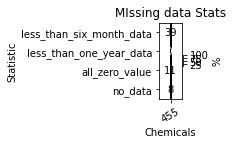

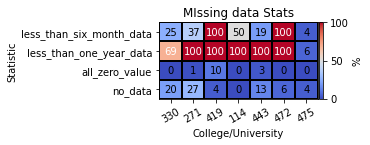

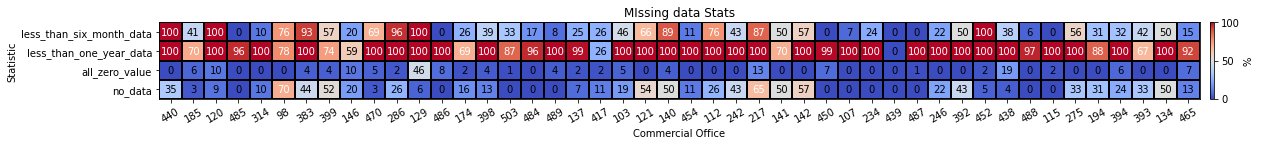

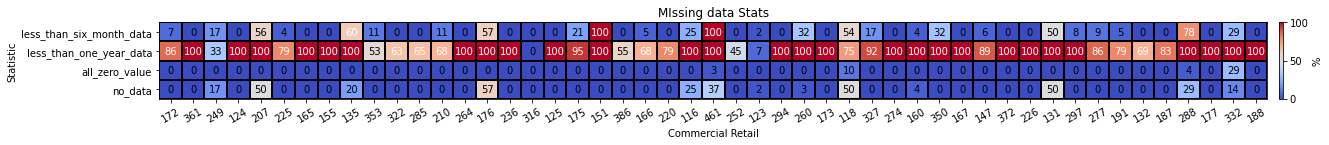

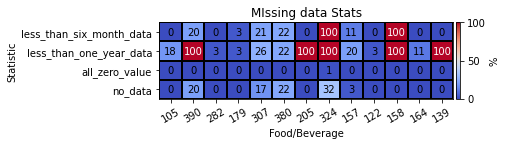

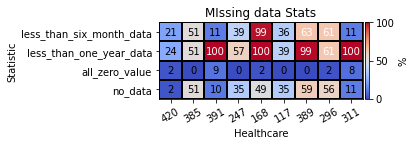

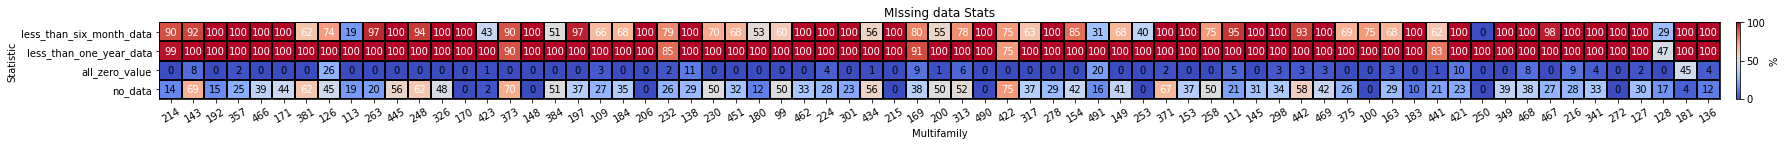

In [64]:
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd

# customer type summary statistics heatmap
cell_y = 0.35
cell_x = cell_y*1.2
cmap = 'coolwarm'
norm = colors.TwoSlopeNorm(vmin=0.0,vcenter=20.0,vmax=100.0)

for c, (customer_type, plot_data) in enumerate(multifamily_highresolution.groupby('customer_type')):
    plot_data['building_id'] = plot_data['building_id'].astype(int).astype(str)
    plot_data = plot_data.drop(columns=['customer_type']).set_index('building_id').T
    x, y, z = plot_data.columns.tolist(), plot_data.index, plot_data.values
    fig, ax = plt.subplots(1,1,figsize=(cell_x*len(x),cell_y*len(y)))
    pcm = ax.pcolormesh(x,y,z,shading='nearest',cmap=cmap,edgecolors='black',linewidth=0.05)
    _ = fig.colorbar(pcm,ax=ax,orientation='vertical',label='%',fraction=0.025,pad=0.01)

    ax.tick_params('x',which='both',rotation=30)
    ax.set_xlabel(customer_type)
    ax.set_ylabel('Statistic')
    ax.set_title('MIssing data Stats')

    # annotate
    for (i, j), z in np.ndenumerate(plot_data):
        color = 'black' if abs(plot_data.iloc[i,j]) < 60 else 'white'
        ax.text(j,i,f'{z:0.0f}',ha='center',va='center',color=color)

    plt.show()

In [12]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily,Hourly

In [13]:
start_weather = datetime(2012, 1, 1)
end_weather = datetime(2021, 12, 31)

In [14]:
NY = Point(40.7143,-74.006,57)
data = Daily(NY, start_weather, end_weather)
data = data.fetch()

In [15]:
NY_weather=data[data.columns[:1]]

In [16]:
NY_weather

tavg
time            
2012-01-01   7.5
2012-01-02   4.0
2012-01-03  -3.8
2012-01-04  -6.7
2012-01-05   0.3
...          ...
2021-12-27   1.0
2021-12-28   5.7
2021-12-29   5.9
2021-12-30   6.0
2021-12-31   7.8

[3653 rows x 1 columns]

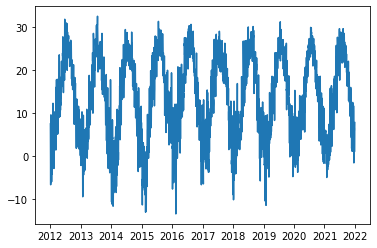

In [17]:
plt.plot(NY_weather['tavg'])

In [18]:
NY_weather.describe()

tavg
count  3651.000000
mean     13.420077
std       9.537161
min     -13.500000
25%       5.600000
50%      13.700000
75%      22.300000
max      32.600000

In [19]:
from onboard.client.models import PointSelector
query = PointSelector()
query.buildings= list(praveen[praveen['info.customerType']=='Multifamily']['id'])
selection = Building_client.select_points(query)
a=selection['equipment_types']
b=selection['point_types']


In [20]:
multi_equ=[]
for i in a:
    eq=Equipment[Equipment['id']==i]['tag_name'].values[0]
    multi_equ.append(eq)

In [21]:
multi_sens=[]
for i in b:
    pt=point_type[point_type['id']==i]['tag_name'].values[0]
    multi_sens.append(pt)

In [22]:
# EQUIPMENTS AND SENSOR TYPES ARE ALL UNIQUE FOR EACH BUILDING, NO EQUIPMENT OR SENSOR TYPES GOT REPEATED 

In [23]:
list(praveen[praveen['info.customerType']=='Multifamily']['id'])[:10]
from datetime import datetime


In [24]:
sensor='Electric Consumption'
query = PointSelector()
start = datetime(2012, 1, 1,00,00,00)
end = datetime(2021, 1, 1,00,00,00)
timezone = pytz.timezone("America/New_York")
start = timezone.localize(start)
end = timezone.localize(end)
for j in list(praveen[praveen['info.customerType']=='Multifamily']['id']):
    query.buildings=[j]
    query.point_types=[sensor]
    selection = Building_client.select_points(query)
    if selection['equipment_types']==0:
        continue
    print(selection['equipment_types'])

[31]
[]
[]
[]
[31]
[31]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[31]
[19, 30]
[]
[]
[31]
[]
[]
[]


total number of sensors for building meter and equipment meter combo is 1


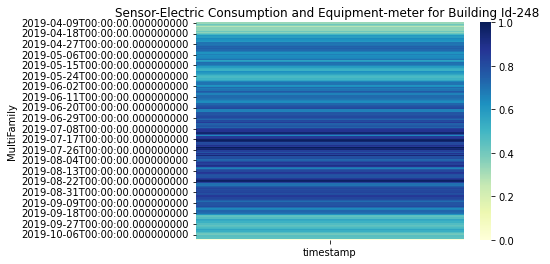

total number of sensors for building meter and equipment meter combo is 1


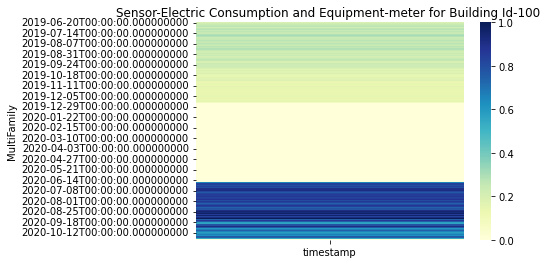

total number of sensors for building meter and equipment meter combo is 1


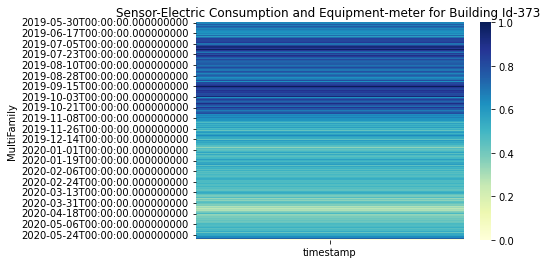

total number of sensors for building meter and equipment meter combo is 1


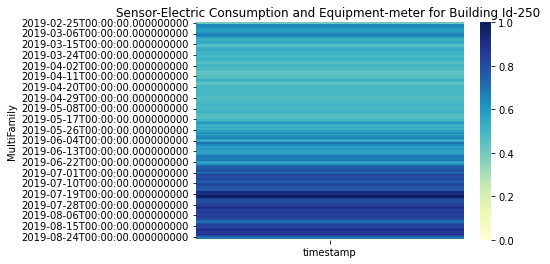

total number of sensors for building boiler and equipment boiler combo is 1


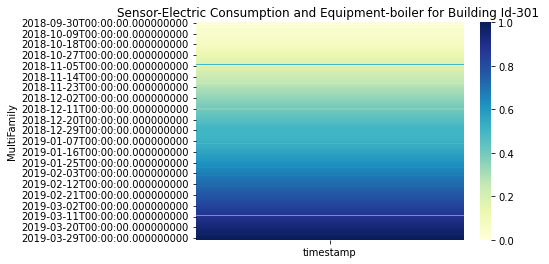

total number of sensors for building hotWaterPlant and equipment hotWaterPlant combo is 1


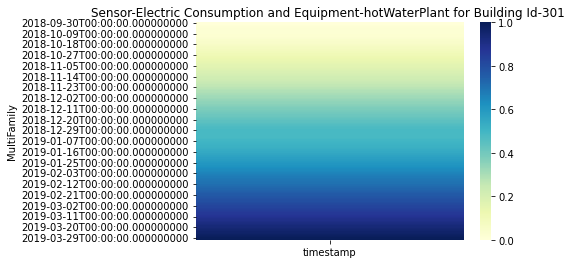

total number of sensors for building meter and equipment meter combo is 1


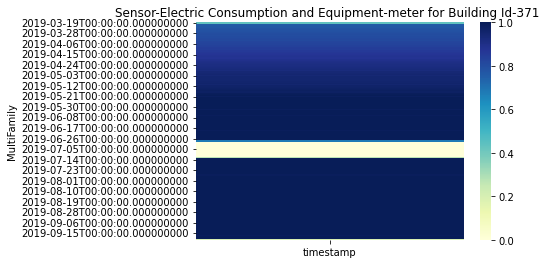

In [23]:
sensor='Electric Consumption'
query = PointSelector()
scaler = MinMaxScaler()
start = datetime(2012, 1, 1,00,00,00)
end = datetime(2021, 1, 1,00,00,00)
timezone = pytz.timezone("America/New_York")
start = timezone.localize(start)
end = timezone.localize(end)
for j in list(praveen[praveen['info.customerType']=='Multifamily']['id']):
    building_id=j
    for i in multi_equ:
        equipment=i
        query.buildings=[building_id]
        query.equipment_types = [equipment]
        query.point_types=[sensor]
        selection = Building_client.select_points(query)
        if len(selection['point_types'])>0:
            print(f'total number of sensors for building {i} and equipment {equipment} combo is',len(selection['point_types']))
            timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start, end = end)
            sensor_data = points_df_from_streaming_timeseries(Building_client.stream_point_timeseries(timeseries_query))
            sensor_data1=pd.DataFrame(sensor_data)
            sensor_data2=sensor_data1.rename(columns={ 'timestamp':'MultiFamily'})
            sensor_data2['MultiFamily']=pd.to_datetime(sensor_data2['MultiFamily'])
            sensor_data3=sensor_data2.set_index(sensor_data2.columns[0])
            sensor_data3=(sensor_data3.resample('D').sum()).mean(axis=1)
            scaler.fit(pd.DataFrame(sensor_data3))
            sensor_data4=scaler.transform(pd.DataFrame(sensor_data3))
            sensor_data5=pd.DataFrame(sensor_data4)
            sensor_data5.index=sensor_data3.index 
            sensor_data6=sensor_data5.rename(columns={ sensor_data5.columns[0]:'timestamp'})
            sns.heatmap(sensor_data6,cmap="YlGnBu")
            plt.title(f"Sensor-{sensor} and Equipment-{i} for Building Id-{building_id} ")
            plt.show()



total number of sensors for building meter and equipment meter combo is 1


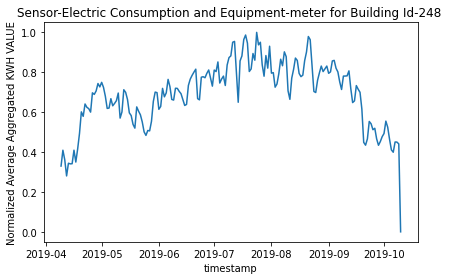

total number of sensors for building meter and equipment meter combo is 1


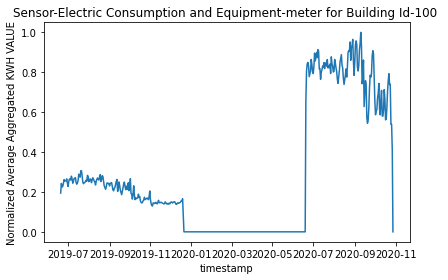

total number of sensors for building meter and equipment meter combo is 1


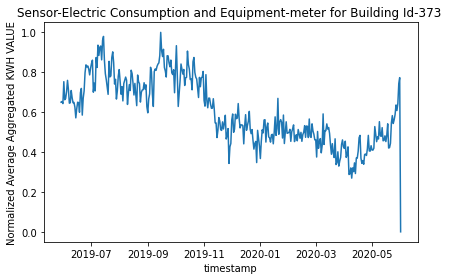

total number of sensors for building meter and equipment meter combo is 1


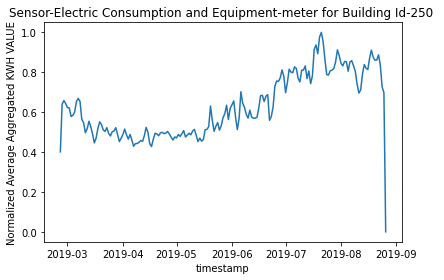

total number of sensors for building boiler and equipment boiler combo is 1


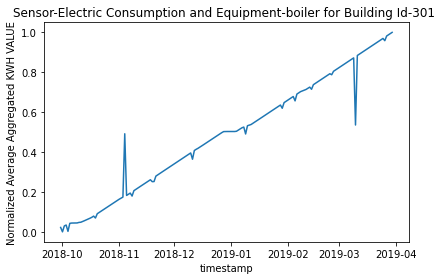

total number of sensors for building hotWaterPlant and equipment hotWaterPlant combo is 1


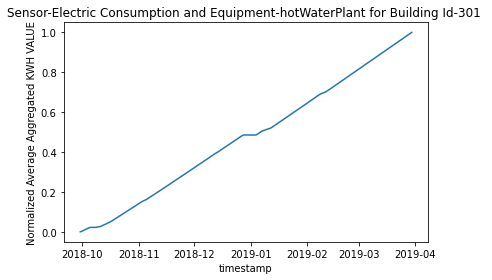

total number of sensors for building meter and equipment meter combo is 1


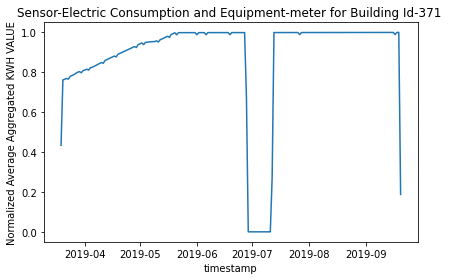

In [119]:
sensor='Electric Consumption'
query = PointSelector()
scaler = MinMaxScaler()
start = datetime(2012, 1, 1,00,00,00)
end = datetime(2021, 1, 1,00,00,00)
timezone = pytz.timezone("America/New_York")
start = timezone.localize(start)
end = timezone.localize(end)
for j in list(praveen[praveen['info.customerType']=='Commerical Office']['id']):
    building_id=j
    for i in multi_equ:
        equipment=i
        query.buildings=[building_id]
        query.equipment_types = [equipment]
        query.point_types=[sensor]
        selection = Building_client.select_points(query)
        if len(selection['point_types'])>0:
            print(f'total number of sensors for building {i} and equipment {equipment} combo is',len(selection['point_types']))
            timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start, end = end)
            sensor_data = points_df_from_streaming_timeseries(Building_client.stream_point_timeseries(timeseries_query))
            sensor_data1=pd.DataFrame(sensor_data)
            sensor_data2=sensor_data1.rename(columns={ 'timestamp':'MultiFamily'})
            sensor_data2['MultiFamily']=pd.to_datetime(sensor_data2['MultiFamily'])
            sensor_data3=sensor_data2.set_index(sensor_data2.columns[0])
            sensor_data3=(sensor_data3.resample('D').sum()).mean(axis=1)
            scaler.fit(pd.DataFrame(sensor_data3))
            sensor_data4=scaler.transform(pd.DataFrame(sensor_data3))
            sensor_data5=pd.DataFrame(sensor_data4)
            sensor_data5.index=sensor_data3.index 
            sensor_data6=sensor_data5.rename(columns={ sensor_data5.columns[0]:'timestamp'})
            plt.plot(sensor_data6['timestamp'])
            plt.xlabel('timestamp')
            plt.ylabel('Normalized Average Aggregated KWH VALUE')
            plt.title(f"Sensor-{sensor} and Equipment-{i} for Building Id-{building_id} ")
            plt.tight_layout()
            plt.show()

total number of sensors for building meter and equipment meter combo is 1


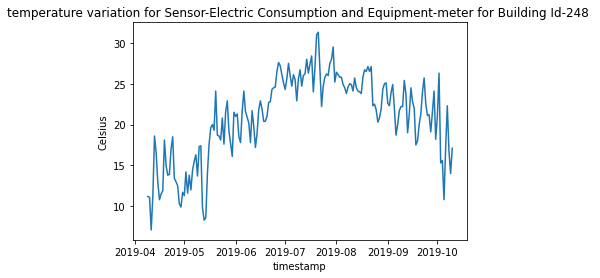

total number of sensors for building meter and equipment meter combo is 1


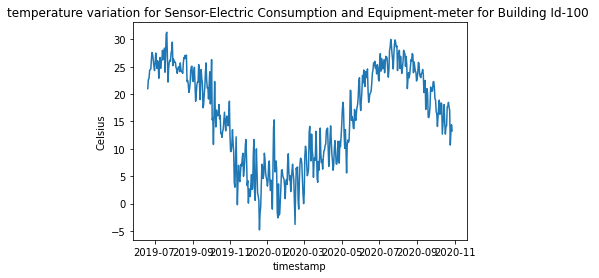

total number of sensors for building meter and equipment meter combo is 1


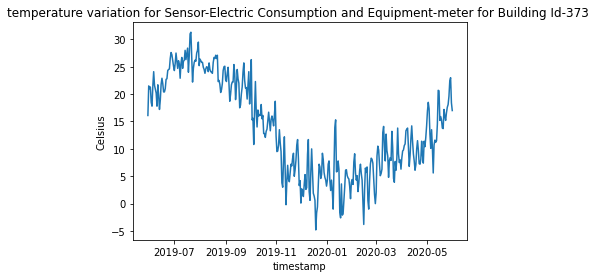

total number of sensors for building meter and equipment meter combo is 1


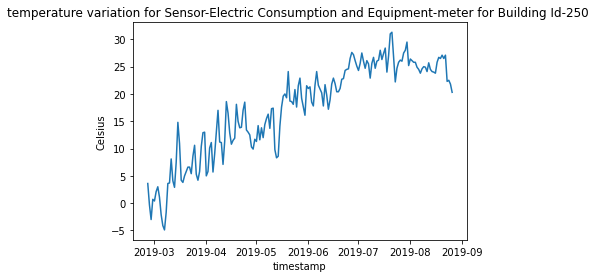

total number of sensors for building boiler and equipment boiler combo is 1


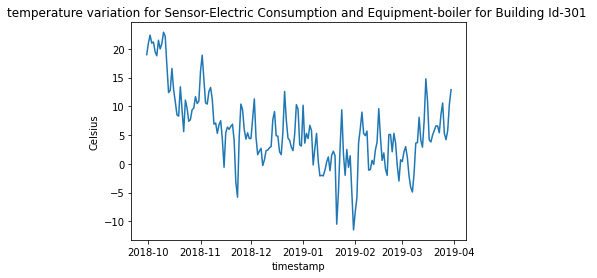

total number of sensors for building hotWaterPlant and equipment hotWaterPlant combo is 1


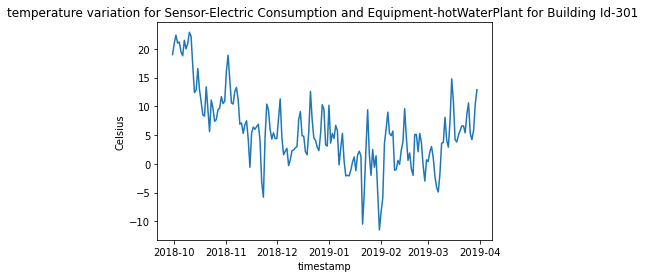

total number of sensors for building meter and equipment meter combo is 1


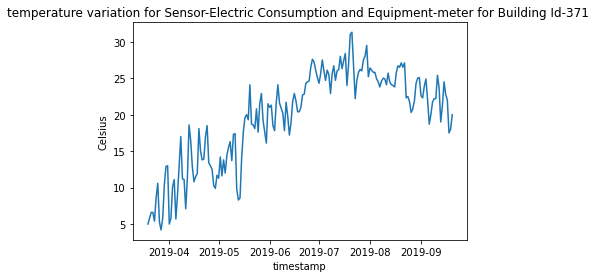

In [118]:
sensor='Electric Consumption'
query = PointSelector()
scaler = MinMaxScaler()
start = datetime(2012, 1, 1,00,00,00)
end = datetime(2021, 1, 1,00,00,00)
timezone = pytz.timezone("America/New_York")
start = timezone.localize(start)
end = timezone.localize(end)
count=0
for j in list(praveen[praveen['info.customerType']=='Multifamily']['id']):
    building_id=j
    for i in multi_equ:
        equipment=i
        query.buildings=[building_id]
        query.equipment_types = [equipment]
        query.point_types=[sensor]
        selection = Building_client.select_points(query)
        if len(selection['point_types'])>0:
            print(f'total number of sensors for building {i} and equipment {equipment} combo is',len(selection['point_types']))
            timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start, end = end)
            sensor_data = points_df_from_streaming_timeseries(Building_client.stream_point_timeseries(timeseries_query))
            sensor_data1=pd.DataFrame(sensor_data)
            sensor_data2=sensor_data1.rename(columns={ 'timestamp':'MultiFamily'})
            sensor_data2['MultiFamily']=pd.to_datetime(sensor_data2['MultiFamily'])
            sensor_data3=sensor_data2.set_index(sensor_data2.columns[0])
            sensor_data3=(sensor_data3.resample('D').sum()).mean(axis=1)
            scaler.fit(pd.DataFrame(sensor_data3))
            sensor_data4=scaler.transform(pd.DataFrame(sensor_data3))
            sensor_data5=pd.DataFrame(sensor_data4)
            sensor_data5.index=sensor_data3.index 
            sensor_data6=sensor_data5.rename(columns={ sensor_data5.columns[0]:'timestamp'})
            a=str(sensor_data6.iloc[:1].index.values)
            start_year=a[2:6]
            start_month=a[7:9]
            if start_month[0]=='0':
                start_month=start_month[1]
            start_date=a[10:12]
            if start_date[0]=='0':
                start_date=start_date[1]
            b=str(sensor_data6.iloc[-1:].index.values)
            end_year=b[2:6]
            end_month=b[7:9]
            if end_month[0]=='0':
                end_month=end_month[1]
            end_date=b[10:12]
            if end_date[0]=='0':
                end_date=end_date[1]
            start_weather1 = datetime(int(start_year), int(start_month), int(start_date))
            end_weather1 = datetime(int(end_year), int(end_month), int(end_date))
            data1 = Daily(NY, start_weather1, end_weather1)
            data1 = data1.fetch()
            temp_weather=data1[data1.columns[:1]]
            plt.plot(temp_weather)
            plt.title(f"temperature variation for Sensor-{sensor} and Equipment-{i} for Building Id-{building_id} ")
            plt.xlabel('timestamp')
            plt.ylabel('Celsius')
            plt.show()



total number of sensors for building meter and equipment meter combo is 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


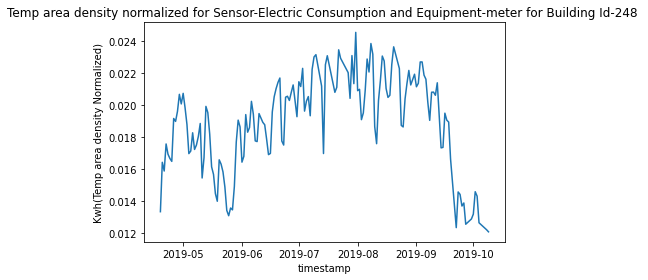

total number of sensors for building meter and equipment meter combo is 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


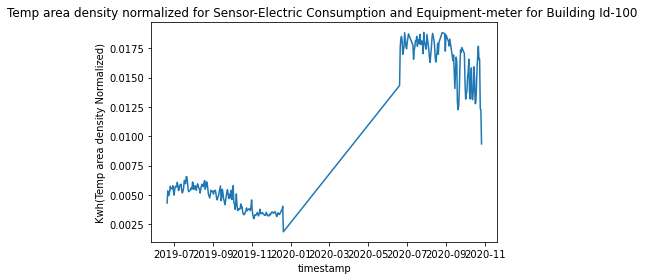

total number of sensors for building meter and equipment meter combo is 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


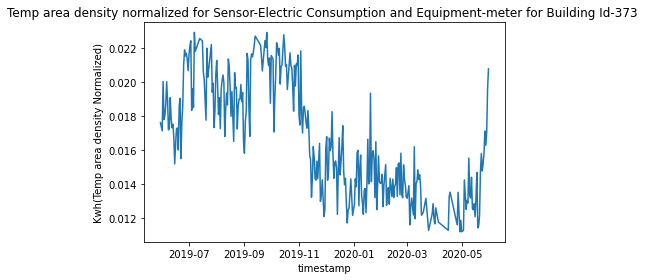

total number of sensors for building meter and equipment meter combo is 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


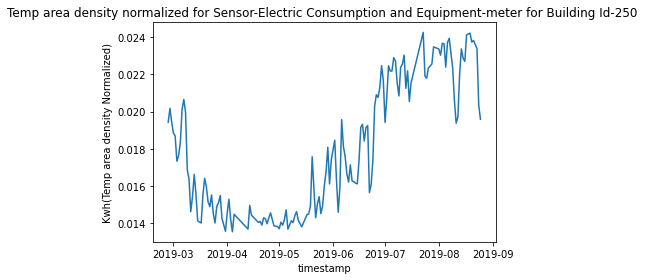

total number of sensors for building boiler and equipment boiler combo is 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


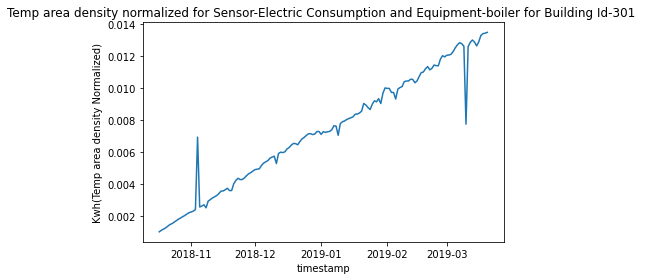

total number of sensors for building hotWaterPlant and equipment hotWaterPlant combo is 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


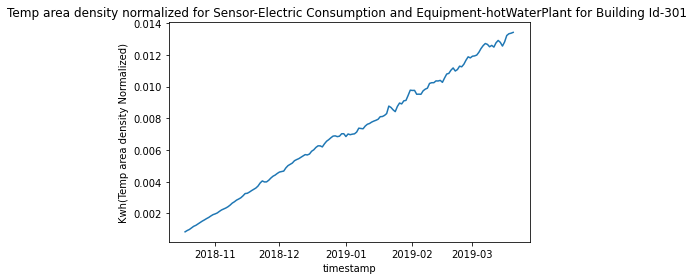

total number of sensors for building meter and equipment meter combo is 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


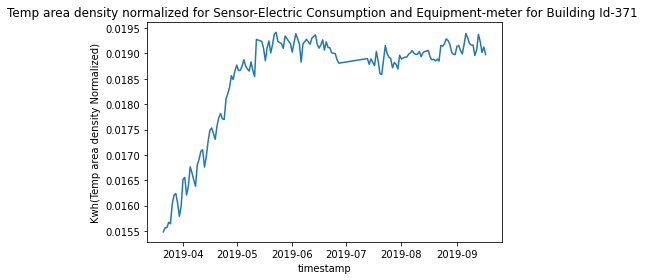

In [224]:
sensor='Electric Consumption'
query = PointSelector()
scaler = MinMaxScaler()
start = datetime(2012, 1, 1,00,00,00)
end = datetime(2021, 1, 1,00,00,00)
timezone = pytz.timezone("America/New_York")
start = timezone.localize(start)
end = timezone.localize(end)
count=0
for j in list(praveen[praveen['info.customerType']=='Multifamily']['id']):
    building_id=j
    area=int(praveen[praveen['id']==building_id]['sq_ft'])*0.000001
    for i in multi_equ:
        equipment=i
        query.buildings=[building_id]
        query.equipment_types = [equipment]
        query.point_types=[sensor]
        selection = Building_client.select_points(query)
        if len(selection['point_types'])>0:
            print(f'total number of sensors for building {i} and equipment {equipment} combo is',len(selection['point_types']))
            timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start, end = end)
            sensor_data = points_df_from_streaming_timeseries(Building_client.stream_point_timeseries(timeseries_query))
            sensor_data1=pd.DataFrame(sensor_data)
            sensor_data2=sensor_data1.rename(columns={ 'timestamp':'MultiFamily'})
            sensor_data2['MultiFamily']=pd.to_datetime(sensor_data2['MultiFamily'])
            sensor_data3=sensor_data2.set_index(sensor_data2.columns[0])
            sensor_data3=(sensor_data3.resample('D').sum()).mean(axis=1)
            scaler.fit(pd.DataFrame(sensor_data3))
            sensor_data4=scaler.transform(pd.DataFrame(sensor_data3))
            sensor_data5=pd.DataFrame(sensor_data4)
            sensor_data5.index=sensor_data3.index 
            sensor_data6=sensor_data5.rename(columns={ sensor_data5.columns[0]:'timestamp'})
            a=str(sensor_data6.iloc[:1].index.values)
            start_year=a[2:6]
            start_month=a[7:9]
            if start_month[0]=='0':
                start_month=start_month[1]
            start_date=a[10:12]
            if start_date[0]=='0':
                start_date=start_date[1]
            b=str(sensor_data6.iloc[-1:].index.values)
            end_year=b[2:6]
            end_month=b[7:9]
            if end_month[0]=='0':
                end_month=end_month[1]
            end_date=b[10:12]
            if end_date[0]=='0':
                end_date=end_date[1]
            start_weather1 = datetime(int(start_year), int(start_month), int(start_date))
            end_weather1 = datetime(int(end_year), int(end_month), int(end_date))
            data1 = Daily(NY, start_weather1, end_weather1)
            data1 = data1.fetch()
            temp_weather=data1[data1.columns[:1]]
            temp_weather['K']=temp_weather['tavg']+273.15
            s1=sensor_data6['timestamp'].values/temp_weather['K']
            s2=pd.DataFrame(s1)
            s3_=s2['K']/area
            s3=pd.DataFrame(s3_)
            s4=s3[s3['K']<s3['K'].quantile(0.95)]
            s5=s4[s4['K']>s4['K'].quantile(0.1)]
            plt.plot(s5)
            plt.title(f"Temp area density normalized for Sensor-{sensor} and Equipment-{i} for Building Id-{building_id} ")
            plt.xlabel('timestamp')
            plt.ylabel('Kwh(Temp area density Normalized)')
            plt.tight_layout()
            plt.show()
    